## Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore", module="numpy")

import os
import argparse
import numpy as np
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from rosbags.rosbag1 import Writer
from rosbags.typesys import Stores, get_typestore
from rosbags.typesys.stores.ros1_noetic import std_msgs__msg__Header as Header
from rosbags.typesys.stores.empty import builtin_interfaces__msg__Time as Time

from generator import GenerateRosbag
from transformations import *

In [2]:
def convert_4x4_matrix_robotics_to_cv(matrix):
    """
    Converts a 4x4 transformation matrix from robotics convention
    (X forward, Y left, Z up) to computer vision convention
    (X right, Y down, Z forward).
    
    Args:
    matrix (np.ndarray): A 4x4 transformation matrix.
    
    Returns:
    np.ndarray: The converted 4x4 transformation matrix.
    """
    # Rotation matrix to convert from robotics to computer vision convention
    R_conversion = np.array([
        [0,  1,  0],
        [1,  0,  0],
        [0,  0, -1]
    ])

    # Extract the 3x3 rotation part and the 3x1 translation part
    R_robotics = matrix[:3, :3]
    t_robotics = matrix[:3, 3]

    # Convert the rotation matrix
    R_cv = R_conversion @ R_robotics

    # Convert the translation vector
    t_cv = R_conversion @ t_robotics

    # Construct the new 4x4 transformation matrix
    matrix_cv = np.eye(4)
    matrix_cv[:3, :3] = R_cv
    matrix_cv[:3, 3] = t_cv

    return matrix_cv


def convert_4x4_matrix_cv_to_robotics(matrix):
    """
    Converts a 4x4 transformation matrix from computer vision convention
    (X right, Y down, Z forward) to robotics convention
    (X forward, Y left, Z up).
    
    Args:
    matrix (np.ndarray): A 4x4 transformation matrix.
    
    Returns:
    np.ndarray: The converted 4x4 transformation matrix.
    """
    # Inverse rotation matrix to convert from computer vision to robotics convention
    R_conversion = np.array([
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, -1]
    ])

    # Extract the 3x3 rotation part and the 3x1 translation part
    R_cv = matrix[:3, :3]
    t_cv = matrix[:3, 3]

    # Convert the rotation matrix
    R_robotics = R_conversion @ R_cv @ R_conversion.T

    # Convert the translation vector
    t_robotics = R_conversion @ t_cv

    # Construct the new 4x4 transformation matrix
    matrix_robotics = np.eye(4)
    matrix_robotics[:3, :3] = R_robotics
    matrix_robotics[:3, 3] = t_robotics

    return matrix_robotics

def rotateZ(matrix, degrees):
    theta = np.radians(degrees)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    rotation_matrix_z = np.array([
        [cos_theta, -sin_theta, 0, 0],
        [sin_theta, cos_theta, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return np.dot(rotation_matrix_z, matrix)

def poses_from_trajectory_file(filename : str):
    poses = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_lines = len(lines)
        i = 0
        
        while i < num_lines:
            image_id = lines[i].strip()  # Read image ID from the first line of the block
            
            # Read the next 4 lines as the transformation matrix
            transformation_matrix = []
            for j in range(1, 5):
                line = lines[i + j].strip()
                matrix_row = np.array([float(x) for x in line.split()])
                transformation_matrix.append(matrix_row)
            
            # Convert the list of lists to a 4x4 NumPy array
            transformation_matrix = np.array(transformation_matrix)
            
            # Append the block (image ID and transformation matrix) to the list of blocks
            #poses.append((image_id, transformation_matrix))
            poses.append(transformation_matrix)
            
            # Move to the next block of 5 lines
            i += 5

    return poses

def intrinsics_from_ini_file(filename):
    parameters = {}
    
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                key, value = line.split()
                parameters[key] = float(value)
    
    fx = parameters.get('fx')
    fy = parameters.get('fy')
    cx = parameters.get('cx')
    cy = parameters.get('cy')
    
    return [fx, fy, cx, cy]

## Read data

In [9]:
# LOAD THE DATASET SCENE
scene_id = 60
v2016 = False # if you are using sceneNN version of 2021, set to False

# LOAD YOUR DATASET PATH
dataset_path = r"../raw_data"
dataset_path = dataset_path + "/{:03d}/".format(scene_id)
print("Dataset path: ", dataset_path)

Dataset path:  ../raw_data/060/


[544.47329, 544.47329, 320.0, 240.0]
2400 2480


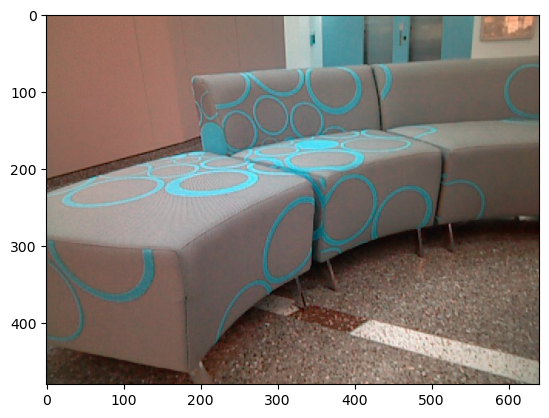

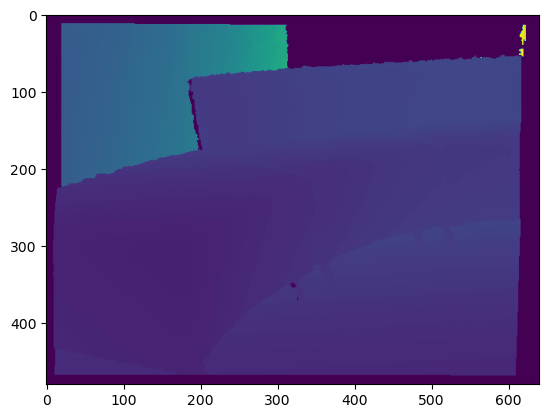

In [16]:
# Data info
n_data = len(os.listdir(dataset_path + "images/image/"))

intrinsics = intrinsics_from_ini_file(dataset_path + "intrinsics/asus.ini")

n = 30
img_rgb = cv2.imread(dataset_path + "images/image/image{:05d}".format(n) + ".png", -1)
img_depth = cv2.imread(dataset_path + "images/depth/depth{:05d}".format(n) + ".png", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 1000.

trajectory_filename = "trajectory.log"
if v2016:
    trajectory_filename = "trajectory2016.log"
poses = poses_from_trajectory_file(dataset_path + trajectory_filename)

print(intrinsics)
print(len(poses), n_data)

plt.imshow(img_rgb)
plt.show()
plt.imshow(img_depth)
plt.show()




## Create rosbag

100%|██████████| 2400/2400 [07:24<00:00,  5.40it/s]


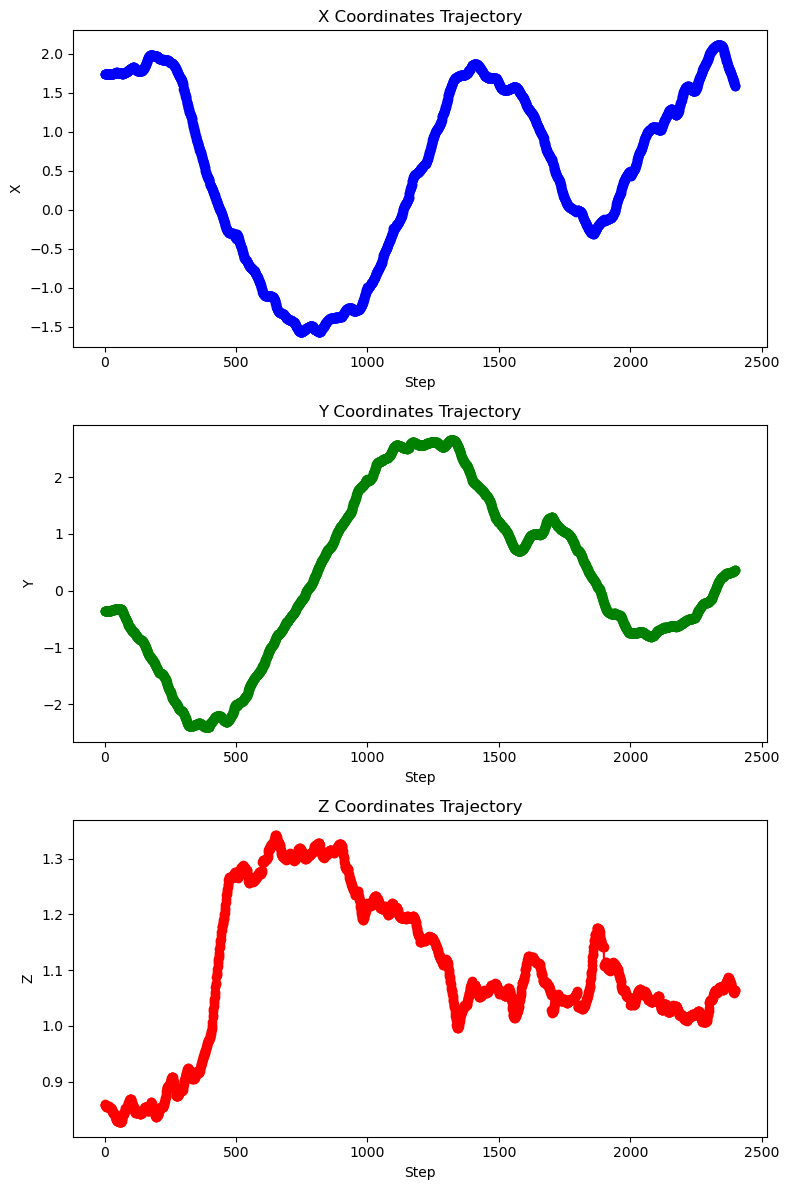

In [18]:
typestore = get_typestore(Stores.ROS1_NOETIC)
rb = GenerateRosbag()

if v2016:
    bag_path = "../to_ros/ROS1_bags/" + "sceneNN_{:03d}_2016".format(scene_id) + ".bag"
else:
    bag_path = "../to_ros/ROS1_bags/" + "sceneNN_{:03d}".format(scene_id) + ".bag"

pose_1 = []
pose_2 = []
pose_3 = []

origin, xaxis, yaxis, zaxis = (0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)
Rx = rotation_matrix(np.radians(90), xaxis)
Ry = rotation_matrix(np.radians(90), yaxis)
Rz = rotation_matrix(np.radians(-90), zaxis)

with Writer(bag_path) as writer:

    camera_rgb = writer.add_connection("camera/rgb", "sensor_msgs/msg/Image", typestore=typestore)
    camera_depth= writer.add_connection("camera/depth", "sensor_msgs/msg/Image", typestore=typestore)
    camera_info = writer.add_connection("camera/camera_info", "sensor_msgs/msg/CameraInfo", typestore=typestore)
    amcl_pose = writer.add_connection("amcl_pose", "geometry_msgs/msg/PoseWithCovarianceStamped", typestore=typestore)
    for i in tqdm(range(min(n_data, len(poses)))):
        
        header = Header(seq=i, stamp=Time(sec=i,nanosec=0), frame_id="camera")

        img_rgb = cv2.imread(dataset_path + "images/image/image{:05d}".format(i+1) + ".png", -1)
        img_depth = cv2.imread(dataset_path + "images/depth/depth{:05d}".format(i+1) + ".png", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 1000.
        
        pose = Rx @ poses[i] @ np.linalg.inv(Ry @ Rz)

        pose_quat = quaternion_from_matrix(pose)
        pose_t = pose[:3,3].reshape(-1)
        pose = [*pose_quat] + [*pose_t]

        pose_1.append(pose_t[0])
        pose_2.append(pose_t[1])
        pose_3.append(pose_t[2])

        rgb_msg = rb.create_image_msg(img_rgb, deepcopy(header))
        rgb_msg = typestore.serialize_ros1(rgb_msg,"sensor_msgs/msg/Image")

        depth_msg = rb.create_image_msg(img_depth, deepcopy(header))
        depth_msg = typestore.serialize_ros1(depth_msg,"sensor_msgs/msg/Image")

        cam_info_msg = rb.create_camera_info_msg(img_rgb, intrinsics, deepcopy(header))
        cam_info_msg = typestore.serialize_ros1(cam_info_msg,"sensor_msgs/msg/CameraInfo")

        pose_msg = rb.create_pose_msg(pose, deepcopy(header))
        pose_msg = typestore.serialize_ros1(pose_msg,"geometry_msgs/msg/PoseWithCovarianceStamped")


        timestamp = int(i * 1e9)
        writer.write(camera_rgb, timestamp, data = rgb_msg)
        writer.write(camera_depth, timestamp, data = depth_msg)
        writer.write(camera_info, timestamp, data = cam_info_msg)
        writer.write(amcl_pose, timestamp, data = pose_msg)


fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot x coordinates trajectory
axs[0].plot(pose_1, marker='o', linestyle='-', color='b')
axs[0].set_title('X Coordinates Trajectory')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('X')

# Plot y coordinates trajectory
axs[1].plot(pose_2, marker='o', linestyle='-', color='g')
axs[1].set_title('Y Coordinates Trajectory')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Y')

# Plot z coordinates trajectory
axs[2].plot(pose_3, marker='o', linestyle='-', color='r')
axs[2].set_title('Z Coordinates Trajectory')
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Z')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

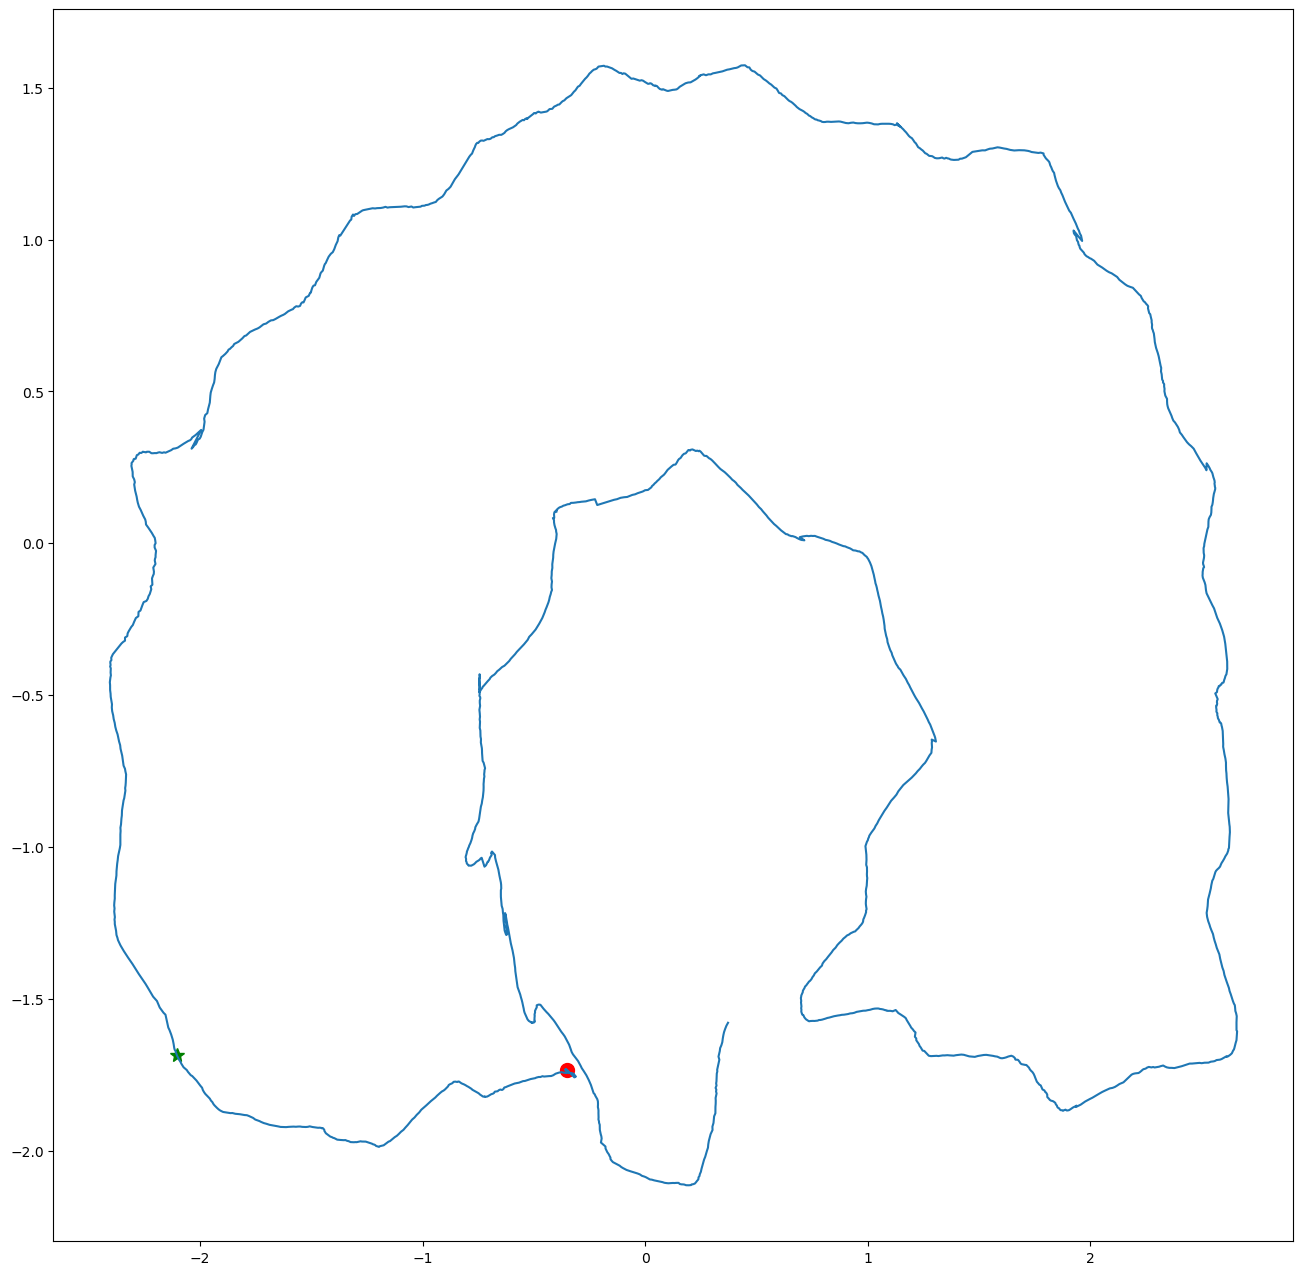

In [19]:
plt.figure(figsize=(16,16))
plt.plot(pose_2[0], -pose_1[0], "ro", markersize=10)
plt.plot(pose_2[288], -pose_1[288], "g*", markersize=10)

plt.plot(pose_2, -np.array(pose_1))

160
128


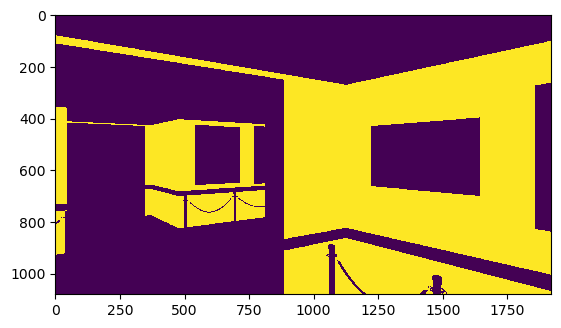

NameError: name 'img_rgb' is not defined

In [8]:
img_seg = cv2.imread(seg_path + "classgt_" + "{0:05d}".format(0) + ".png", -1)

img_seg_bn = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)
print(img_seg_bn[600,1000])


img_seg_bn = cv2.cvtColor(cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2GRAY)
print(img_seg_bn[600,1000])

plt.imshow(img_seg_bn == 128)
plt.show()
plt.imshow(img_rgb)
print(img_seg.shape)

print(img_seg_bn[0,0])

In [5]:
print(tf_msg)

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 0
        nsecs:         0
      frame_id: "base_link"
    child_frame_id: "camera"
    transform: 
      translation: 
        x: 0.0
        y: 0.0
        z: 0.0
      rotation: 
        x: 0.0
        y: 0.0
        z: 0.0
        w: 1.0
  - 
    header: 
      seq: 0
      stamp: 
        secs: 0
        nsecs:         0
      frame_id: "map"
    child_frame_id: "base_link"
    transform: 
      translation: 
        x: -2.5515585659689273
        y: 1.903976052088743
        z: 1.6499999999999997
      rotation: 
        x: 2.010366508708899e-17
        y: 0.0
        z: -0.32831776641372745
        w: 0.9445673241700955
